In [1]:
import collections

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import numpy as np

import curiosidade


%load_ext autoreload
%autoreload 2

/media/nvme/prober/venvs/py3.9.10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Torch setup

In [2]:
import numpy as np
import torch

loss_fn = torch.nn.CrossEntropyLoss()

rnd_state = np.random.RandomState(8)
torch.random.manual_seed(32)

n, m = 400, 4
X = torch.from_numpy(rnd_state.randn(n, m)).float()
y = X.mean(axis=1).round().abs().long()

train_size = int(0.9 * n)
eval_size = int(0.05 * n)
test_size = n - train_size - eval_size

df = torch.utils.data.TensorDataset(X, y)
df_train, df_eval, df_test = torch.utils.data.random_split(
    df, lengths=[train_size, eval_size, test_size],
)

probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=10,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=10,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=10,
    shuffle=False,
)

num_cls = y.unique().numel()
X.shape, y.shape, num_cls

(torch.Size([400, 4]), torch.Size([400]), 2)

In [3]:
# class ProbingModel(torch.nn.Module):
#     def __init__(self, input_dim: int, output_dim: int):
#         super().__init__()
#         self.params = torch.nn.Sequential(
#             torch.nn.Linear(input_dim, 20, bias=True),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Linear(20, output_dim, bias=True),
#         )
    
#     def forward(self, X):
#         return self.params(X)


ProbingModel = curiosidade.probers.utils.get_probing_model_feedforward(hidden_layer_dims=[20])

In [4]:
import collections
import torch
import torch.nn


class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.params = torch.nn.Sequential(
            collections.OrderedDict((
                ("lin1", torch.nn.Linear(X.shape[1], 15, bias=True)),
                ("relu1", torch.nn.ReLU(inplace=True)),
                ("lin2", torch.nn.Linear(15, 25, bias=True)),
                ("relu2", torch.nn.ReLU(inplace=True)),
                ("lin3", torch.nn.Linear(25, num_cls)),
            )),
        )
    
    def forward(self, X):
        return self.params(X)


base_model = BaseModel()
optim_base = torch.optim.Adam(base_model.parameters(), lr=0.01)

beta = 0.9
mov_avg_loss = 0.0

base_model = base_model.train()
for _ in range(50):
    for X_batch, y_batch in probing_dataloader_train:
        optim_base.zero_grad()
        y_logits = base_model(X_batch)
        loss = loss_fn(input=y_logits, target=y_batch)
        loss.backward()
        optim_base.step()
        mov_avg_loss = beta * mov_avg_loss + (1.0 - beta) * float(loss.cpu().detach().item())
    
    print(f"{mov_avg_loss=:.3f}")

mov_avg_loss=0.534
mov_avg_loss=0.257
mov_avg_loss=0.148
mov_avg_loss=0.125
mov_avg_loss=0.085
mov_avg_loss=0.118
mov_avg_loss=0.089
mov_avg_loss=0.062
mov_avg_loss=0.072
mov_avg_loss=0.084
mov_avg_loss=0.127
mov_avg_loss=0.088
mov_avg_loss=0.052
mov_avg_loss=0.057
mov_avg_loss=0.051
mov_avg_loss=0.039
mov_avg_loss=0.043
mov_avg_loss=0.055
mov_avg_loss=0.032
mov_avg_loss=0.063
mov_avg_loss=0.036
mov_avg_loss=0.040
mov_avg_loss=0.031
mov_avg_loss=0.062
mov_avg_loss=0.044
mov_avg_loss=0.051
mov_avg_loss=0.032
mov_avg_loss=0.042
mov_avg_loss=0.024
mov_avg_loss=0.029
mov_avg_loss=0.088
mov_avg_loss=0.055
mov_avg_loss=0.039
mov_avg_loss=0.040
mov_avg_loss=0.063
mov_avg_loss=0.036
mov_avg_loss=0.027
mov_avg_loss=0.035
mov_avg_loss=0.016
mov_avg_loss=0.037
mov_avg_loss=0.040
mov_avg_loss=0.029
mov_avg_loss=0.079
mov_avg_loss=0.087
mov_avg_loss=0.046
mov_avg_loss=0.022
mov_avg_loss=0.016
mov_avg_loss=0.020
mov_avg_loss=0.059
mov_avg_loss=0.020


## Curiosidade setup

In [29]:
import torchmetrics


def metrics_fn(logits: torch.Tensor, truth_labels: torch.Tensor) -> dict[str, float]:
    accuracy = torchmetrics.Accuracy(num_classes=2)(logits, truth_labels)
    f1 = torchmetrics.F1Score(num_classes=2)(logits, truth_labels)
    return {"accuracy": accuracy, "f1": f1}


task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=loss_fn,
    task_name="debug_task",
    task_type="classification",
    output_dim=num_cls,
    metrics_fn=metrics_fn,
)

import functools

probing_factory = curiosidade.ProbingModelFactory(
    probing_model_fn=ProbingModel,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.001),
    task=task,
)

prober_container = curiosidade.attach_probers(
    base_model=base_model,
    probing_model_factory=probing_factory,
    modules_to_attach="relu\d+",
    random_seed=16,
    prune_unrelated_modules=None,
)

print(f"{prober_container = }")
print(f"{prober_container.probed_modules = }")

prober_container = ProbingModelContainer:
(a): Base model: BaseModel(
  (params): Sequential(
    (lin1): Linear(in_features=4, out_features=15, bias=True)
    (relu1): ReLU(inplace=True)
    (lin2): Linear(in_features=15, out_features=25, bias=True)
    (relu2): ReLU(inplace=True)
    (lin3): Linear(in_features=25, out_features=2, bias=True)
  )
)
(b): Task name: debug_task
(c): Probing dataset(s):
  (train):   36 batches of size (at most) 10.
  (eval) :    2 batches of size (at most) 10.
  (test) :    2 batches of size (at most) 10.
(d): Probed module(s) (2 in total):
  (0): params.relu1
  (1): params.relu2
(e): No pruned modules.
prober_container.probed_modules = ('params.relu1', 'params.relu2')


In [30]:
probing_results = prober_container.train(num_epochs=20)

In [7]:
probing_results

ProbingResults(
    train = MetricPack with 4320 values stored in:
      (0, 'loss', 'params.relu1', 1): 0.7079402208328247
      (0, 'accuracy', 'params.relu1', 1): 0.5
      (0, 'f1', 'params.relu1', 1): 0.5
      (0, 'loss', 'params.relu2', 1): 0.551925778388977
      ...,
    eval  = MetricPack with 240 values stored in:
      (0, 'loss', 'params.relu1', 1): 0.7371053099632263
      (0, 'accuracy', 'params.relu1', 1): 0.10000000149011612
      (0, 'f1', 'params.relu1', 1): 0.10000000894069672
      (0, 'loss', 'params.relu2', 1): 0.4280572831630707
      ...,
    test  = MetricPack with 12 values stored in:
      (-1, 'loss', 'params.relu1', 1): 0.16445784270763397
      (-1, 'accuracy', 'params.relu1', 1): 0.8999999761581421
      (-1, 'f1', 'params.relu1', 1): 0.8999999761581421
      (-1, 'loss', 'params.relu2', 1): 0.22506138682365417
      ...,
)

    epoch        module metric_name    metric          
                                         mean       std
0       0  params.relu1    accuracy  0.330556  0.158239
1       0  params.relu1          f1  0.330556  0.158239
2       0  params.relu1        loss  0.732363  0.050406
3       0  params.relu2    accuracy  0.900000  0.147358
4       0  params.relu2          f1  0.900000  0.147358
..    ...           ...         ...       ...       ...
115    19  params.relu1          f1  0.980556  0.046718
116    19  params.relu1        loss  0.071176  0.050137
117    19  params.relu2    accuracy  0.997222  0.016667
118    19  params.relu2          f1  0.997222  0.016667
119    19  params.relu2        loss  0.014359  0.021337

[120 rows x 5 columns]


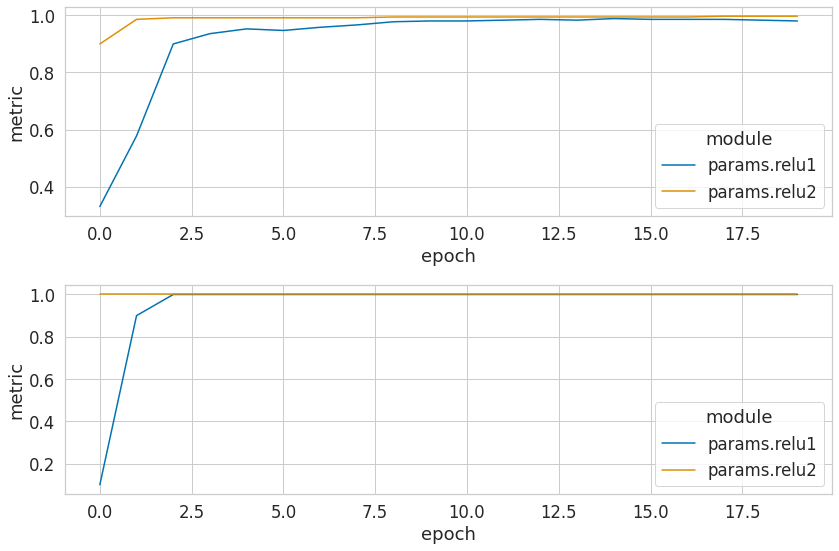

In [8]:
def create_plot(data, ax, split):
    df = data.to_pandas()
    df = df.groupby(["epoch", "module", "metric_name"]).agg({"metric": np.mean}).reset_index()
    df = df.loc[df["metric_name"] == "accuracy", :]
    sns.lineplot(x="epoch", y="metric", hue="module", data=df, ax=ax);

    
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    palette="colorblind",
)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

create_plot(probing_results.train, ax=ax1, split="train")
create_plot(probing_results.eval, ax=ax2, split="eval")

print(probing_results.train.to_pandas(["epoch", "module", "metric_name"], aggregate_fn=[np.mean, np.std]))

plt.tight_layout()

## Test with BERT

In [31]:
import transformers

transformer_model = transformers.BertForTokenClassification.from_pretrained(
    "../../segmentador/pretrained_segmenter_model/2_6000_layer_model/"
)

In [32]:
import datasets

data = datasets.Dataset.load_from_disk(
    "../../segmentador/data/df_tokenized_split_0_120000_6000/eval/"
).shard(num_shards=15, index=0)

def fn_pad(item):
    new_item = {}
    for k, v in item.items():
        if k != "labels":
            if len(v) < 512:
                new_item[k] = v + (512 - len(v)) * [0]
            else:
                new_item[k] = v[:512]
            
    total_segments = sum(lab == 1 for lab in item["labels"])
    
    if total_segments > 20:
        new_label = 0
    elif 20 >= total_segments > 10:
        new_label = 1
    else:
        new_label = 2
    
    new_item["labels"] = new_label
            
    return new_item

num_cls = 3

data = data.map(fn_pad)
data.set_format("torch")
df_train, aux = data.train_test_split(test_size=0.1, shuffle=True).values()
df_eval, df_test = aux.train_test_split(test_size=0.5, shuffle=False).values()
df_train, df_eval, df_test

Loading cached processed dataset at ../../segmentador/data/df_tokenized_split_0_120000_6000/eval/cache-c9502c531385ac30.arrow


(Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 862
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 48
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 48
 }))

In [11]:
# class ProbingModel(torch.nn.Module):
#     def __init__(self, input_dim: int, output_dim: int):
#         super().__init__()
#         self.params = torch.nn.Sequential(
#             torch.nn.Linear(input_dim, 128),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Linear(128, output_dim),
#         )
    
#     def forward(self, X):
#         out = X
#         out, _ = out.max(axis=1)
#         out = self.params(out)
#         return out

In [33]:
ProbingModel = curiosidade.probers.utils.get_probing_model_for_sequences(hidden_layer_dims=[128])

In [34]:
import torch

probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=4,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=8,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=8,
    shuffle=False,
)

In [41]:
import functools

loss_fn = torch.nn.CrossEntropyLoss()

def accuracy_fn(logits, target):
    _, cls_ids = logits.max(axis=-1)
    return {"accuracy": (cls_ids == target).float().mean().item()}

task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=loss_fn,
    task_name="debug_task_bert",
    output_dim=num_cls,
    metrics_fn=accuracy_fn,
)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=ProbingModel,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.005),
)

prober = curiosidade.core.attach_probers(
    base_model=transformer_model,
    probing_model_factory=probing_factory,
    modules_to_attach="bert.encoder.layer.0.output.dense",
    device="cuda",
    prune_unrelated_modules=None,
)

prober

ProbingModelContainer:
(a): Base model: BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(6000, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [42]:
probing_res = prober.train(
    num_epochs=3,
    show_progress_bar=True,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:13<00:00, 15.95it/s]


   epoch                             module metric_name    metric
0     -1  bert.encoder.layer.0.output.dense    accuracy  0.729167
1     -1  bert.encoder.layer.0.output.dense        loss  0.675937
2     -1  bert.encoder.layer.1.output.dense    accuracy  0.729167
3     -1  bert.encoder.layer.1.output.dense        loss  0.838226


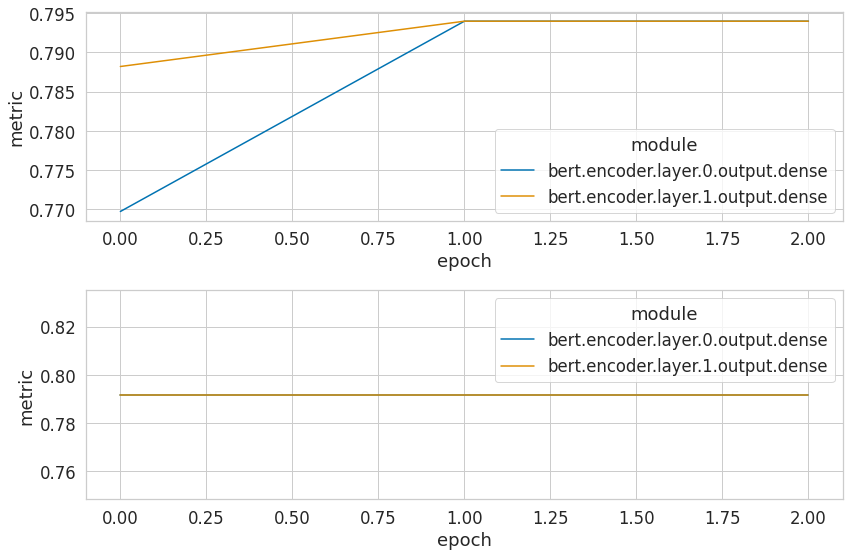

In [16]:
def create_plot(data, ax, split):
    df = data.to_pandas(aggregate_by=["epoch", "module", "metric_name"])
    df = df.loc[df["metric_name"] == "accuracy"]
    sns.lineplot(x="epoch", y="metric", hue="module", data=df, ax=ax);

    
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    palette="colorblind",
)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

create_plot(probing_res.train, ax=ax1, split="train")
create_plot(probing_res.eval, ax=ax2, split="eval")

print(probing_res.test.to_pandas(["epoch", "module", "metric_name"]))

plt.tight_layout()